### 1. Find base_lr and max_lr
Calculate the upper bound of the learning rate for your model. The way to do this is to:
1. Define an initial learning rate, the lower boundary of the range you want to test (let’s say 1e-7)
2. Define an upper boundary of the range (let’s say 0.1)
3. Define an exponential scheme to run through this step by step: <br>
```python
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( data_loader["train"])))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
```
<br>
Note: Youdon’t take the ‘raw’ loss at each step, but the smoothed loss, being: loss = α . loss + (1- α). previous_loss

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torchsummary import summary
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
hyperparam = {
    "data" : {
        "stake_training_data" : 0.9, 
        "path" : '../../../data/vega_shrinkwrapper_original/NewBlade/'
    },
    "model" : {
        "input_size" : 7,
        "n_hidden" : 150,
        "sequence_size" : 50,
        "batch_size" : 8,
        "lstm_layer" : 3,
    },
    "cycling_lr" : {
        # step_size is the number of training iterations (total samples/batch_size) per half cycle. 
        # Authors suggest setting step_size 2-8 x training iterations in epoch.
        "step_size" : (2048/8)*2, 
        # Mode can be one of {triangular, triangular2, exp_range}
        "mode" : "triangular2", 
        "gamma" : 0.9995,
        "base_lr" : 3e-3, 
        "max_lr" :5e-3
    },
    "training": {
        "n_epochs" : 10,
        "patience" : 50,
    }
}

# Split train and test data

In [3]:
class DataPreperator():
    def __init__(self, path):
        self.path = path
        
    def load_data(self):
        return pd.read_csv(self.path)
    
    def preprocess_data(self, train_data, validation_data):
        # Remove time feature
        train_data = train_data.drop(labels="Timestamp", axis=1)
        validation_data = validation_data.drop(labels="Timestamp", axis=1)
        # Initialise standard scaler
        scaler = StandardScaler()
        scaler.fit(train_data)
        # Transform data
        train_scaled = scaler.transform(train_data)
        validation_scaled = scaler.transform(validation_data)
        return train_scaled, validation_scaled
        
    def provide_data(self, stake_training_data):
        dataset = self.load_data()
        amount_training_data = round(len(dataset)*stake_training_data)
        train_data = dataset.iloc[0:amount_training_data,:]
        validation_data = dataset.iloc[amount_training_data:,:]
        train_preprocessed, validation_preporcessed = self.preprocess_data(train_data, validation_data)
        
        return train_preprocessed, validation_preporcessed

In [4]:
train_loader = DataPreperator(path=hyperparam['data']['path']+'NewBlade001.csv')
train_data, validation_data = train_loader.provide_data(stake_training_data=hyperparam['data']['stake_training_data'])


In [5]:
class DataSet(Dataset):
    def __init__(self, data, timesteps):
        # Data as numpy array is provided
        self.data = data
        # Data generator is initialized, batch_size=1 is indipendent of neural network's batch_size 
        self.generator = TimeseriesGenerator(self.data, self.data, length=timesteps, batch_size=1)

    def __getitem__(self, index):
        x, y = self.generator[index]
        x_torch = torch.from_numpy(x)
        # Dimension 0 with size 1 (created by TimeseriesGenerator because of batch_size=1) gets removed 
        # because DataLoader will add a dimension 0 with size=batch_size as well
        x_torch = torch.squeeze(x_torch) # torch.Size([1, timesteps, 7]) --> torch.Size([timesteps, 7])
        y_torch = torch.from_numpy(y)
        y_torch = torch.squeeze(y_torch)
        return (x_torch.float(), y_torch.float()) 

    def __len__(self):
        return len(self.generator)

In [6]:
dataset_train = DataSet(train_data, timesteps=hyperparam["model"]["sequence_size"])
dataset_validation = DataSet(validation_data, timesteps=hyperparam["model"]["sequence_size"])

# Data is shuffled because each mini batch is indipendent from each other, but samples of a minibatch are in chronological order
data_loader_training = DataLoader(dataset_train, batch_size=hyperparam["model"]["batch_size"], 
                                  num_workers=1, shuffle=True, drop_last=True)
data_loader_validation = DataLoader(dataset_validation, batch_size=hyperparam["model"]["batch_size"], 
                                    num_workers=1, shuffle=True, drop_last=True)

In [7]:
class LSTM(nn.Module):
    def __init__(self, batch_size, input_dim, n_hidden, n_layers):
        super(LSTM, self).__init__()
        # Attributes for LSTM Network
        self.input_dim = input_dim
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        # Definition of NN layer
        # batch_first = True because dataloader creates batches and batch_size is 0. dimension
        self.lstm = nn.LSTM(input_size = self.input_dim, hidden_size = self.n_hidden, num_layers = self.n_layers, batch_first = True)
        self.fc_y_hat = nn.Linear(self.n_hidden, self.input_dim)
        
    def forward(self, input_data, hidden):
        # Forward propagate LSTM
        # LSTM in Pytorch return two results the first one usually called output and the second one (hidden_state, cell_state). 
        # As output the LSTM returns all the hidden_states for all the timesteps (seq), in other words all of the hidden states throughout
        # the sequence
        # As hidden_state the LSTM returns just the most recent hidden state
        lstm_out, (hidden_state, cell_state) = self.lstm(input_data, hidden)
        # Length of input data can varry 
        length_seq = input_data.size()[1]
        # Select the output from the last sequence 
        last_out = lstm_out[:,length_seq-1,:]
        out_y_hat = self.fc_y_hat(last_out)
        return out_y_hat
    
    def init_hidden(self):
        # This method is for initializing hidden state as well as cell state
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        h0 = torch.zeros(self.n_layers, self.batch_size, self.n_hidden, requires_grad=False)
        c0 = torch.zeros(self.n_layers, self.batch_size, self.n_hidden, requires_grad=False)
        return [t for t in (h0, c0)]

# Training

In [80]:
model = LSTM(batch_size=hyperparam['model']['batch_size'], input_dim=hyperparam['model']['input_size'], 
             n_hidden=hyperparam['model']['n_hidden'], n_layers=hyperparam['model']['lstm_layer'])

# Experiment parameters
lr_find_epochs = 7
start_lr = 1e-3
end_lr = 3
smoothing = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=start_lr)  
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len(data_loader_training)))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Make lists to capture the logs
lr_find_loss = []
lr_find_lr = []

for i in range(lr_find_epochs):
    epoch_training_loss = []
    print("epoch {}".format(i))
    for batch_number, data in enumerate(data_loader_training):
        
        input_data, target_data = data
        # Training mode and zero gradients
        model.train()
        hidden = model.init_hidden()
        optimizer.zero_grad()

        # Get outputs to calc loss
        output = model(input_data, hidden)
        
        # Computate loss
        criterion = nn.MSELoss()
        loss = criterion(output, target_data)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update LR
        scheduler.step()
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        # smooth the loss
        if batch_number==0:
          lr_find_loss.append(loss.item())
        else:
          loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
          lr_find_loss.append(loss)

epoch 0
[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ...

Traceback (most recent call last):
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [74]:
import numpy as np
import pandas as pd
data = pd.DataFrame(data={'iteration': range(len(lr_find_lr)), 'learning_rate': lr_find_lr, 'loss': lr_find_loss})
data['log_value'] = np.log(data['learning_rate'])
data.head()

,iteration,learning_rate,loss,log_value
0,0,0.001005,0.669570,-6.902649
1,1,0.001010,0.676117,-6.897543
2,2,0.001015,0.675663,-6.892437
3,3,0.001021,0.675208,-6.887331
4,4,0.001026,0.674404,-6.882225


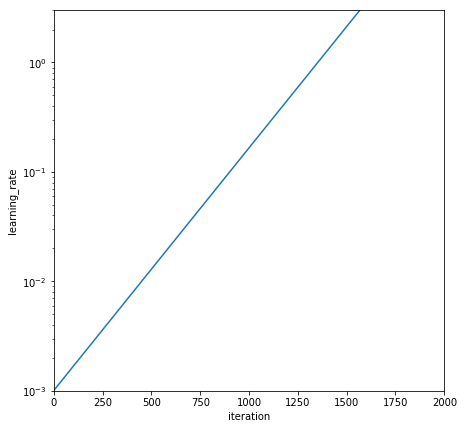

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
plt.ylim(start_lr, end_lr)
plt.xlim(0, 2000)

sns.lineplot(x=data.iteration, y=data.learning_rate, ax=ax)
plt.show()

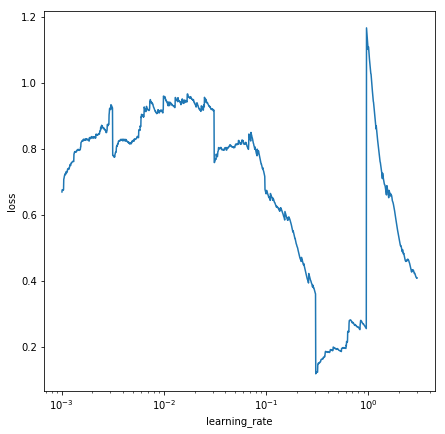

In [76]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sns.lineplot(x=data.learning_rate, y=data.loss, ax=ax)
plt.show()

__Example for possible outcome:__
![](../../knowledge/pictures/learning_rate.png)

- A good upper bound (max_lr) is not on the lowest point, but about a factor of 10 to the left. (In this case 3e-3)
- A good lower bound (base_lr), according to the paper and other sources, is the upper bound, divided by a factor 6.